<a href="https://colab.research.google.com/github/ochekroun/projet-ia/blob/master/classification-images/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !python -V

In [2]:
#!pip install -r requirements.txt

In [3]:
# !pip install tensorflow==2.16.2
# !pip install keras==3.4.1

In [4]:
# utilisons pytorch plutôt que tensorflow
import os
os.environ["KERAS_BACKEND"] = "torch"

In [25]:
import keras
from keras import layers
from keras.applications import EfficientNetB0
import requests
import tarfile
import os
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
import json
from torch.utils.data import Dataset
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [6]:
#!rm -rf ./data/nuswide_81/


In [7]:
download_file = False

from pathlib import Path
Path("./data").mkdir(parents=True, exist_ok=True)

if download_file:
    def decompress(tar_file, file_path, members=None):
        """
        Extracts `tar_file` and puts the `members` to `path`.
        If members is None, all members on `tar_file` will be extracted.
        """
        tar = tarfile.open(tar_file, mode="r:gz")
        if members is None:
            members = tar.getmembers()
        # with progress bar
        # set the progress bar
        progress = tqdm(members)
        for member in progress:
            tar.extract(member, path=file_path)
            # set the progress description of the progress bar
            progress.set_description(f"Extracting {member.name}")

        tar.close()

    def download(url, file_path):
        # Streaming, so we can iterate over the response.
        response = requests.get(url, stream=True)

        # Sizes in bytes.
        total_size = int(response.headers.get("content-length", 0))
        block_size = 4096

        with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
            with open(file_path, "wb") as file:
                for data in response.iter_content(block_size):
                    progress_bar.update(len(data))
                    file.write(data)

        if total_size != 0 and progress_bar.n != total_size:
            raise RuntimeError("Could not download file")


    download('https://olivierchekroun.blob.core.windows.net/documents/projet-ia/nus_wide.tar.gz','./data/nus_wide.tar.gz')
    decompress('./data/nus_wide.tar.gz', './data/nuswide_81')
    
    download('https://olivierchekroun.blob.core.windows.net/documents/projet-ia/data.tar.gz','./data/data.tar.gz')
    decompress('./data/data.tar.gz', './data/')



check_image_file = False
if check_image_file:
    image_dir = './data/images'
    bad_image_file_path = './data/bad_images.txt'
    IMG_SIZE = 224
    size = (IMG_SIZE, IMG_SIZE)
    count = 0
    try:
        os.remove(bad_image_file_path)
    except OSError:
        pass
    arr = os.listdir(image_dir)
    print(len(arr))
    bad_files = []
    for image_name in tqdm(arr):
        count += 1
        imagePath = os.path.join(image_dir, image_name)
        try:
            image = Image.open(imagePath)
            image.load()
            image = tf.image.resize(image, size)
            image = image.numpy()
        except Exception as e:
            print(f'{e} {imagePath}')
            bad_files.append(image_name)
            continue
    print(f'Images count: {count}')

    print(bad_files)

    with open(bad_image_file_path, 'w') as f:
        for line in bad_files:
            f.write(f"{line}\n")

In [8]:
def load_labels():
    labels = []
    with open('./data/labels.txt') as f:
        lines = f.read().splitlines()
        for line in lines:
            labels.append(line)
    return labels

def load_dataframe(file_name):
    with open('./data/bad_images.txt', 'r') as file:
        bad_files = file.read().splitlines()

    print(f'Bad files {bad_files}')

    labels = load_labels()

    # Étape 1 : Charger la liste des images

    with open(file_name) as f:
        all_samples_data = f.read().splitlines()


    image_names =[]
    string_values = []
    array_values = []
    given_labels = []
    for data_line in tqdm(all_samples_data):
        parts = data_line.split(' ')
        image_name = parts[0]
        array_value = np.asarray(list(map(int, parts[1:])))
        string_value = ' '.join(parts[1:])

        given_label = np.array(labels)[np.argwhere(array_value)[:, 0]]
        #print(given_labels)

        image_names.append(image_name)
        string_values.append(string_value)
        array_values.append(array_value)
        given_labels.append(given_label)

    # Étape 3 : Créer le DataFrame
    data = {'Image': image_names, 'Values': array_values, 'String_Values': string_values, 'Given_Labels': given_labels}
    df = pd.DataFrame(data)
    print(f'Dataframe length: {len(df)}')

    # Étape 4 : Exclure les lignes où il n'y a que des 0 dans les tableaux de valeurs
    df_filtered = df
    df_filtered = df[df['Values'].apply(lambda x: any(x))]
    df_filtered = df_filtered[~df_filtered['Image'].isin(bad_files)]
    # if stratify :
    #     df_filtered = df_filtered.groupby('String_Values').filter(lambda x: len(x) > 1)
    print(f'Dataframe filtered length: {len(df_filtered)}')

    return df_filtered

In [9]:
df = load_dataframe('./data/database.txt')
labels = load_labels()

Bad files ['164_369098387_98c20067_1306855694.jpg', '65_1306855694_9063340002_b.jpg', '24831_2545048982_3b384d0444_m.jpg']


100%|██████████| 218491/218491 [00:05<00:00, 38393.89it/s]


Dataframe length: 218491
Dataframe filtered length: 169823


In [10]:
%%time
stratify = False
num_class = df['String_Values'].nunique()
print(num_class)
train_size = 1000
val_size = num_class if stratify else int(train_size * 0.2)
test_size = 0.5

if stratify:
    train_df, val_df = train_test_split(
        df,
        stratify = df['String_Values'].values,
        train_size = train_size,
        test_size= val_size
        )
else:
    train_df, val_df = train_test_split(
        df,
        train_size = train_size,
        test_size= val_size
        )

    train_df, test_df = train_test_split(
        train_df,
        test_size = test_size
    )

print("Number of images for training: ", len(train_df))
print("Number of images for validation: ", len(val_df))
print("Number of images for test: ", len(test_df))



# df = load_dataframe('./data/nuswide_81/test.txt')
# num_class = df['String_Values'].nunique()
# print(num_class)
# val_size = num_class if stratify else int(train_size * 0.2)
# if stratify:
#     test_df, _ = train_test_split(
#         df,
#         stratify = df['String_Values'].values,
#         train_size=val_size
#         )
# else:
#     test_df, _ = train_test_split(
#     df,
#     train_size=val_size,
# )
# print("Number of images for test: ", len(test_df))

16249
Number of images for training:  500
Number of images for validation:  200
Number of images for test:  500
CPU times: user 99.1 ms, sys: 0 ns, total: 99.1 ms
Wall time: 108 ms


In [11]:
def write_df(df, labels, file_path):
    rows = []
    for index, row in test_df[['Image', 'Given_Labels']].iterrows():
        row_image = row['Image']
        row_labels = row['Given_Labels'].tolist()
        row = {'image_name': row_image, 'image_labels': row_labels}
        rows.append(row)
    with open(file_path, 'w') as fp:
        json.dump({'samples': rows, 'labels': labels}, fp, indent=3)

write_df(train_df, labels, './data/train.json')
write_df(val_df, labels, './data/val.json')
write_df(test_df, labels, './data/test.json')

In [12]:
from torchvision import transforms
class NusDataset(Dataset):
    def __init__(self, anno_path, transforms):
        self.transforms = transforms
        with open(anno_path) as fp:
            json_data = json.load(fp)
        samples = json_data['samples']
        self.classes = json_data['labels']

        self.imgs = []
        self.annos = []
        print('loading', anno_path)
        for sample in samples:
            self.imgs.append(sample['image_name'])
            self.annos.append(sample['image_labels'])
        for item_id in range(len(self.annos)):
            item = self.annos[item_id]
            vector = [cls in item for cls in self.classes]
            self.annos[item_id] = np.array(vector, dtype=float)

    def __getitem__(self, item):
        anno = self.annos[item]
        try:
            IMG_SIZE = 224
            size = (IMG_SIZE, IMG_SIZE)
            img_path = self.imgs[item]
            image = Image.open(img_path)
            if self.transforms is not None:
                image = self.transforms(image)
            #image = tf.image.resize(image, size)
            # image = image.numpy()
        except Exception as e:
            print(f'{e} {img_path}')
        return image, anno

    def __len__(self):
        return len(self.imgs)

def image_processing(image):
    IMG_SIZE = 224
    size = (IMG_SIZE, IMG_SIZE)    
    image = tf.image.resize(image, size)
    image = image.numpy()
    return image

In [13]:
#!ls ./data/nuswide_81/images/11781_1590858672_d446580056_m.jpg

loading ./data/test.json


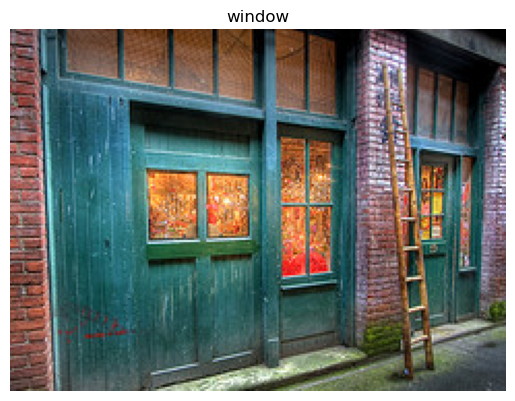

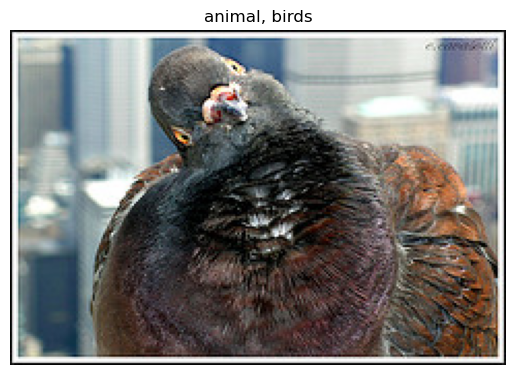

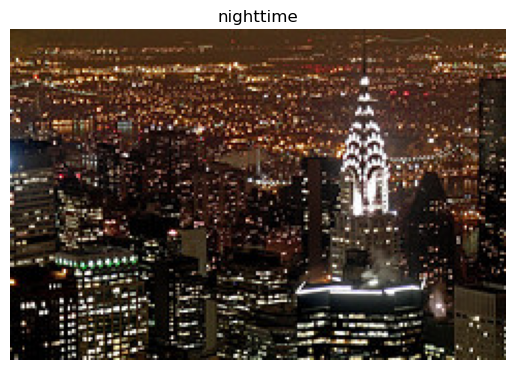

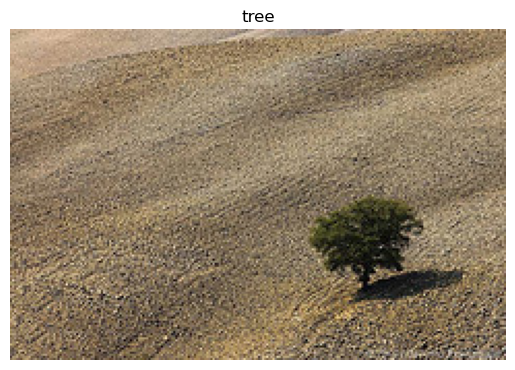

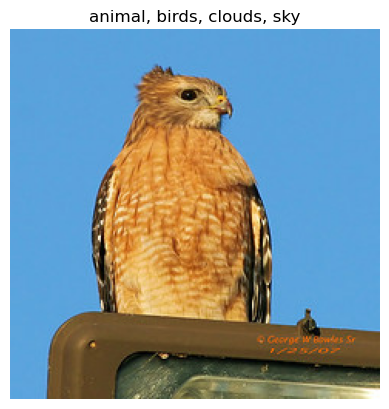

In [14]:
# Let's take a look at the data we have. To do it we need to load the dataset without augmentations.
samples_ds = NusDataset('./data/test.json', None)

# A simple function for visualization.
def show_sample(img, binary_img_labels):
    # Convert the binary labels back to the text representation.
    img_labels = np.array(samples_ds.classes)[np.argwhere(binary_img_labels > 0)[:, 0]]
    plt.imshow(img)
    plt.title("{}".format(', '.join(img_labels)))
    plt.axis('off')
    plt.show()

for sample_id in range(5):
    img, labels = samples_ds[sample_id]
    show_sample(img, labels)

In [15]:
train_ds = NusDataset('./data/train.json', image_processing)
val_ds = NusDataset('./data/val.json', image_processing)
test_ds = NusDataset('./data/test.json', image_processing)

batch_size = 32
num_workers = 8
num_classes = len(train_ds.classes)

train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, num_workers=num_workers)
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=num_workers)

loading ./data/train.json
loading ./data/val.json
loading ./data/test.json


In [18]:
def build_model(num_classes):
    inputs = layers.Input(shape=(224, 224, 3))

    # On retire les dernières couches avec "include_top=False"
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # "Glace" the paramètres pré-entrainés
    model.trainable = False

    # On rajoute les couches retirées - ces couches sont entrainables !
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)

    # On peut ajuster le ratio de neurones désactivés pour la couche Dropout
    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation='sigmoid', name="predictions")(x)

    # Compile le nouveau modèle
    model = keras.Model(inputs, outputs, name="EfficientNet")

    # On augmente le learning rate du défaut 0.001 à 0.01
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)

    model.compile(
         optimizer=optimizer,
         loss=tf.keras.metrics.binary_crossentropy,
         metrics=["binary_accuracy"]
    )
    return model

In [19]:
model = build_model(num_classes)

In [ ]:
def unfreeze_model(model):
    # On rends entrainable les derniers 20 layers (sauf ceux de BatchNormalization)
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
          layer.trainable = True

    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss=tf.keras.metrics.binary_crossentropy, metrics=["binary_accuracy"]
    )


unfreeze_model(model)

In [ ]:
#!pip list| grep keras

In [34]:
history = model.fit(x=train_dl,validation_data=val_dl,epochs=10)
model.save('simple_model_without_unfreeze.keras')

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - binary_accuracy: 0.9746 - loss: 0.0935 - val_binary_accuracy: 0.9801 - val_loss: 0.0633
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - binary_accuracy: 0.9850 - loss: 0.0554 - val_binary_accuracy: 0.9877 - val_loss: 0.0413
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - binary_accuracy: 0.9890 - loss: 0.0429 - val_binary_accuracy: 0.9947 - val_loss: 0.0299
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - binary_accuracy: 0.9930 - loss: 0.0336 - val_binary_accuracy: 0.9966 - val_loss: 0.0231
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - binary_accuracy: 0.9957 - loss: 0.0264 - val_binary_accuracy: 0.9982 - val_loss: 0.0187
Epoch 6/10
 6/15 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - binary_accuracy: 0.9959 - loss: 0.0188 

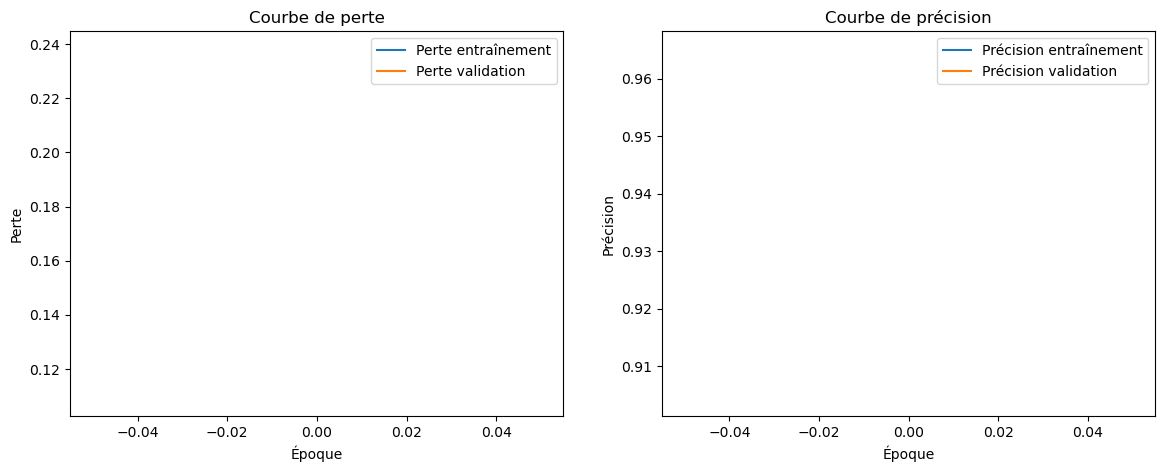

In [33]:
# Récupération des données de l'historique
loss = history.history['loss']
val_loss = history.history['val_loss']
binary_accuracy = history.history['binary_accuracy']
val_binary_accuracy = history.history['val_binary_accuracy']

# Tracé des courbes de perte
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(loss, label='Perte entraînement')
plt.plot(val_loss, label='Perte validation')
plt.title('Courbe de perte')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()

# Tracé des courbes de précision
plt.subplot(1, 2, 2)
plt.plot(binary_accuracy, label='Précision entraînement')
plt.plot(val_binary_accuracy, label='Précision validation')
plt.title('Courbe de précision')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()

plt.show()

In [ ]:
model = keras.saving.load_model('simple_model.keras')
model.evaluate(x=test_dl)

In [ ]:
# Run inference on the test data
samples_ds = NusDataset('./data/test.json', image_processing)
for sample_id in range(5, 15):
    test_img, test_labels = samples_ds[sample_id]
    test_img_path = samples_ds.imgs[sample_id]
    test_img = np.expand_dims(test_img, axis=0)
    # raw_pred  = model(test_img, training = False)[0]
    raw_pred = model(test_img, training = False).cpu()[0]
    raw_pred = np.array(raw_pred > 0.5, dtype=float)

    predicted_labels = np.array(samples_ds.classes)[np.argwhere(raw_pred > 0)[:, 0]]
    print(len(predicted_labels))
    if not len(predicted_labels):
        predicted_labels = ['no predictions']
    img_labels = np.array(samples_ds.classes)[np.argwhere(test_labels > 0)[:, 0]]
    plt.imshow(Image.open(test_img_path))
    plt.title("Predicted labels: {} \nGT labels: {}".format(', '.join(predicted_labels), ', '.join(img_labels)))
    plt.axis('off')
    plt.show()